(array([0.07984805, 0.06533357, 0.06275669, 0.06702705, 0.06674594]),
 array([0.07984805, 0.06346062, 0.0709665 , 0.07117742, 0.07033305,
        0.07296022]))

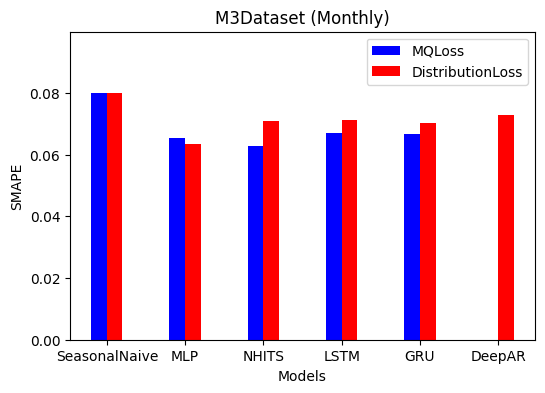

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_smape(dataset_name, group):

    if f"{dataset_name}_{group}_MQLoss" not in os.listdir("original_results") or f"{dataset_name}_{group}_DistributionLoss" not in os.listdir("original_results") :
        return

    MQL = pd.read_csv(f"original_results/{dataset_name}_{group}_MQLoss/smape_{dataset_name}_{group}_MQLoss.csv")
    DL = pd.read_csv(f"original_results/{dataset_name}_{group}_DistributionLoss/smape_{dataset_name}_{group}_DistributionLoss.csv")

    MQL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in MQL.columns]
    DL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in DL.columns]

    MQL_means = MQL.drop(columns='unique_id').mean()
    DL_means = DL.drop(columns='unique_id').mean()

    y_max = max(MQL_means.max(), DL_means.max())

    combined_means = pd.concat([MQL_means, DL_means], axis=1)
    combined_means.columns = ['MQL', 'DL']

    fig, ax = plt.subplots(figsize=(6, 4))

    bar_width = 0.2
    index = np.arange(len(combined_means))

    bar1 = ax.bar(index, combined_means['MQL'], bar_width, label='MQLoss', color='b')
    bar2 = ax.bar(index + bar_width, combined_means['DL'], bar_width, label='DistributionLoss', color='r')

    ax.set_xlabel('Models')
    ax.set_ylabel('SMAPE')
    ax.set_ylim(0, 1.25*y_max)
    ax.set_title(f'{dataset_name} ({group})')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(combined_means.index)
    ax.legend(loc='upper right')

    plt.savefig(f"plots/smape/smape_{dataset_name}_{group}.png")

    return MQL_means.values, DL_means.values

plot_smape("M3Dataset", "Monthly")

array([[0.89377289, 0.89377289,        nan],
       [0.94380072, 0.95134592, 0.93248858],
       [0.94800163, 0.93548262, 0.92038096],
       [0.93826878, 0.94215619, 0.9224449 ],
       [0.93673254, 0.94202265, 0.91119656],
       [       nan, 0.91849279,        nan]])

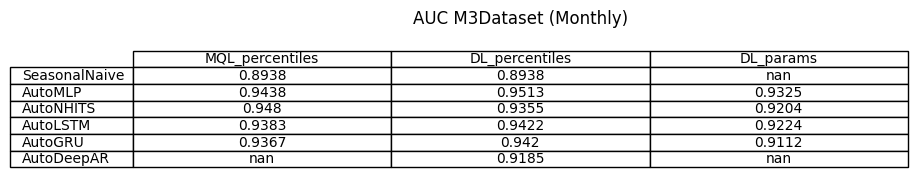

In [2]:
def plot_auc(dataset_name, group):
    
    if f"{dataset_name}_{group}_MQLoss" not in os.listdir("original_results") or f"{dataset_name}_{group}_DistributionLoss" not in os.listdir("original_results") :
        return
    
    MQL_percentiles = pd.read_csv(f"original_results/{dataset_name}_{group}_MQLoss/auc_logloss_percentiles_{dataset_name}_{group}_MQLoss.csv")
    DL_percentiles = pd.read_csv(f"original_results/{dataset_name}_{group}_DistributionLoss/auc_logloss_percentiles_{dataset_name}_{group}_DistributionLoss.csv")
    DL_params = pd.read_csv(f"original_results/{dataset_name}_{group}_DistributionLoss/auc_logloss_params_{dataset_name}_{group}_DistributionLoss.csv")

    matrix = {}
    for df_name, df in [('MQL_percentiles', MQL_percentiles), ("DL_percentiles", DL_percentiles), ("DL_params", DL_params)]:
        auc_means = {}
        for model in ['SeasonalNaive', 'AutoMLP', 'AutoNHITS', 'AutoLSTM', 'AutoGRU', 'AutoDeepAR']:
            auc = df[df['Model_Percentile'].isin([model+'_90', model+'_95', model+'_99'])]['AUC'].mean() 
            auc_means[model] = auc
        matrix[df_name] = auc_means

    auc_df = pd.DataFrame(matrix)

    fig, ax = plt.subplots(figsize=(10, 2))  # Set figure size
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=auc_df.round(4).values, colLabels=auc_df.columns, rowLabels=auc_df.index, cellLoc='center', loc='center')
    plt.title(f'AUC {dataset_name} ({group})')
    plt.savefig(f"plots/auc/auc_{dataset_name}_{group}.png")

    return auc_df.values

plot_auc("M3Dataset", "Monthly")

array([[0.37905244, 0.37905244,        nan],
       [0.27240176, 0.24739525, 0.51813006],
       [0.25615362, 0.28163166, 0.52664739],
       [0.27655652, 0.26786285, 0.5271703 ],
       [0.28487542, 0.29295243, 0.52197021],
       [       nan, 0.36135849,        nan]])

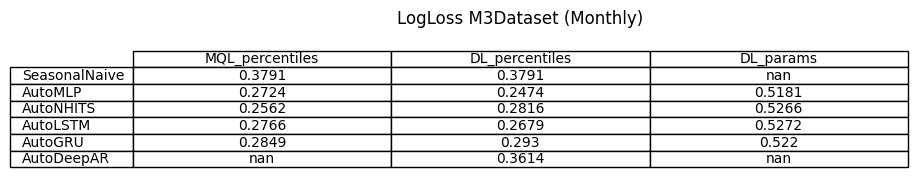

In [3]:
def plot_logloss(dataset_name, group):
    
    if f"{dataset_name}_{group}_MQLoss" not in os.listdir("original_results") or f"{dataset_name}_{group}_DistributionLoss" not in os.listdir("original_results") :
        return
    
    MQL_percentiles = pd.read_csv(f"original_results/{dataset_name}_{group}_MQLoss/auc_logloss_percentiles_{dataset_name}_{group}_MQLoss.csv")
    DL_percentiles = pd.read_csv(f"original_results/{dataset_name}_{group}_DistributionLoss/auc_logloss_percentiles_{dataset_name}_{group}_DistributionLoss.csv")
    DL_params = pd.read_csv(f"original_results/{dataset_name}_{group}_DistributionLoss/auc_logloss_params_{dataset_name}_{group}_DistributionLoss.csv")

    matrix = {}
    for df_name, df in [('MQL_percentiles', MQL_percentiles), ("DL_percentiles", DL_percentiles), ("DL_params", DL_params)]:
        auc_means = {}
        for model in ['SeasonalNaive', 'AutoMLP', 'AutoNHITS', 'AutoLSTM', 'AutoGRU', 'AutoDeepAR']:
            auc = df[df['Model_Percentile'].isin([model+'_90', model+'_95', model+'_99'])]['LogLoss'].mean() 
            auc_means[model] = auc
        matrix[df_name] = auc_means

    auc_df = pd.DataFrame(matrix)

    fig, ax = plt.subplots(figsize=(10, 2))  # Set figure size
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=auc_df.round(4).values, colLabels=auc_df.columns, rowLabels=auc_df.index, cellLoc='center', loc='center')
    plt.title(f'LogLoss {dataset_name} ({group})')
    plt.savefig(f"plots/logloss/logloss_{dataset_name}_{group}.png")

    return auc_df.values

plot_logloss("M3Dataset", "Monthly")

In [4]:
from codebase.load_data.m3 import M3Dataset
from codebase.load_data.tourism import TourismDataset
from codebase.load_data.gluonts import GluontsDataset
from matplotlib.pyplot import close

for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():
        plot_smape(dataset.DATASET_NAME, group); close()
        plot_auc(dataset.DATASET_NAME, group); close()
        plot_logloss(dataset.DATASET_NAME, group); close()

/home/tonicardoso/anaconda3/envs/investigacao/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


['constant',
 'exchange_rate',
 'solar-energy',
 'electricity',
 'traffic',
 'exchange_rate_nips',
 'electricity_nips',
 'traffic_nips',
 'solar_nips',
 'wiki2000_nips',
 'wiki-rolling_nips',
 'taxi_30min',
 'kaggle_web_traffic_with_missing',
 'kaggle_web_traffic_without_missing',
 'kaggle_web_traffic_weekly',
 'm1_yearly',
 'm1_quarterly',
 'm1_monthly',
 'nn5_daily_with_missing',
 'nn5_daily_without_missing',
 'nn5_weekly',
 'tourism_monthly',
 'tourism_quarterly',
 'tourism_yearly',
 'cif_2016',
 'london_smart_meters_without_missing',
 'wind_farms_without_missing',
 'car_parts_without_missing',
 'dominick',
 'fred_md',
 'pedestrian_counts',
 'hospital',
 'covid_deaths',
 'kdd_cup_2018_without_missing',
 'weather',
 'm3_monthly',
 'm3_quarterly',
 'm3_yearly',
 'm3_other',
 'm4_hourly',
 'm4_daily',
 'm4_weekly',
 'm4_monthly',
 'm4_quarterly',
 'm4_yearly',
 'm5',
 'uber_tlc_daily',
 'uber_tlc_hourly',
 'airpassengers',
 'australian_electricity_demand',
 'electricity_hourly',
 'elec

/tmp/ipykernel_11967/3576699033.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  smape_global_MQL = pd.concat([smape_global_MQL, smape_MQL], axis=0)
/tmp/ipykernel_11967/3576699033.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  smape_global_DL = pd.concat([smape_global_DL, smape_DL], axis=0)


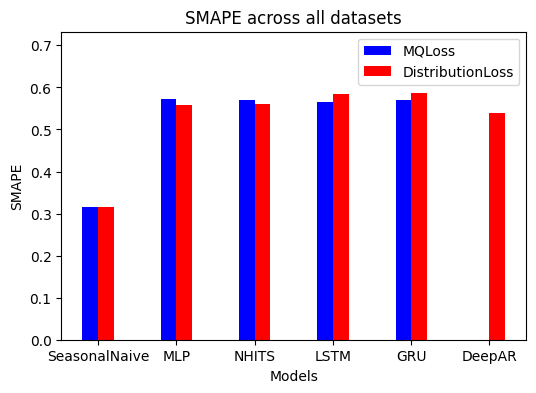

In [9]:
smape_global_MQL = pd.DataFrame(columns=['unique_id','SeasonalNaive','MLP','NHITS','LSTM','GRU'])
smape_global_DL = pd.DataFrame(columns=['unique_id','SeasonalNaive','MLP','NHITS','LSTM','GRU','DeepAR'])


for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():
        smape_MQL = pd.read_csv(f"original_results/{dataset._DATASET_NAME}_{group}_MQLoss/smape_{dataset._DATASET_NAME}_{group}_MQLoss.csv")
        smape_DL = pd.read_csv(f"original_results/{dataset._DATASET_NAME}_{group}_DistributionLoss/smape_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")

        smape_MQL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_MQL.columns]
        smape_DL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_DL.columns]

        smape_global_MQL = pd.concat([smape_global_MQL, smape_MQL], axis=0)
        smape_global_DL = pd.concat([smape_global_DL, smape_DL], axis=0)


smape_global_MQL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_global_MQL.columns]
smape_global_DL.columns = [col.removeprefix("Auto").removesuffix("-median") for col in smape_global_DL.columns]

MQL_means = smape_global_MQL.drop(columns='unique_id').mean()
DL_means = smape_global_DL.drop(columns='unique_id').mean()

y_max = max(MQL_means.max(), DL_means.max())

combined_means = pd.concat([MQL_means, DL_means], axis=1)
combined_means.columns = ['MQL', 'DL']

fig, ax = plt.subplots(figsize=(6, 4))

bar_width = 0.2
index = np.arange(len(combined_means))

bar1 = ax.bar(index, combined_means['MQL'], bar_width, label='MQLoss', color='b')
bar2 = ax.bar(index + bar_width, combined_means['DL'], bar_width, label='DistributionLoss', color='r')

ax.set_xlabel('Models')
ax.set_ylabel('SMAPE')
ax.set_ylim(0, 1.25*y_max)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(combined_means.index)
ax.legend(loc='upper right')
ax.set_title("SMAPE across all datasets")
plt.savefig("plots/smape_global_mean.png")


/tmp/ipykernel_11967/386404752.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  auc_global_MQL_percentiles = pd.concat([auc_global_MQL_percentiles, MQL_percentiles], axis=0)
/tmp/ipykernel_11967/386404752.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  auc_global_DL_percentiles = pd.concat([auc_global_DL_percentiles, DL_percentiles], axis=0)
/tmp/ipykernel_11967/386404752.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a futur

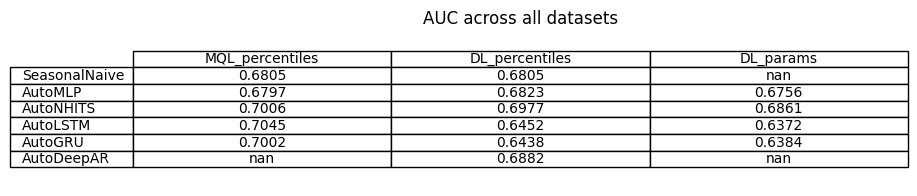

In [6]:
auc_global_MQL_percentiles = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])
auc_global_DL_percentiles = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])
auc_global_DL_params = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])

for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():
        MQL_percentiles = pd.read_csv(f"original_results/{dataset._DATASET_NAME}_{group}_MQLoss/auc_logloss_percentiles_{dataset._DATASET_NAME}_{group}_MQLoss.csv")
        DL_percentiles = pd.read_csv(f"original_results/{dataset._DATASET_NAME}_{group}_DistributionLoss/auc_logloss_percentiles_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")
        DL_params = pd.read_csv(f"original_results/{dataset._DATASET_NAME}_{group}_DistributionLoss/auc_logloss_params_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")
        
        auc_global_MQL_percentiles = pd.concat([auc_global_MQL_percentiles, MQL_percentiles], axis=0)
        auc_global_DL_percentiles = pd.concat([auc_global_DL_percentiles, DL_percentiles], axis=0)
        auc_global_DL_params = pd.concat([auc_global_DL_params, DL_params], axis=0)

matrix = {}
for df_name, df in [('MQL_percentiles', auc_global_MQL_percentiles), ("DL_percentiles", auc_global_DL_percentiles), ("DL_params", auc_global_DL_params)]:
    auc_means = {}
    for model in ['SeasonalNaive', 'AutoMLP', 'AutoNHITS', 'AutoLSTM', 'AutoGRU', 'AutoDeepAR']:
        auc = df[df['Model_Percentile'].isin([model+'_90', model+'_95', model+'_99'])]['AUC'].mean() 
        auc_means[model] = auc
    matrix[df_name] = auc_means

auc_df = pd.DataFrame(matrix)

fig, ax = plt.subplots(figsize=(10, 2))  # Set figure size
ax.axis('tight')
ax.axis('off')
ax.set_title("AUC across all datasets")

table = ax.table(cellText=auc_df.round(4).values, colLabels=auc_df.columns, rowLabels=auc_df.index, cellLoc='center', loc='center')
plt.savefig("plots/auc_global_mean.png")

/tmp/ipykernel_11967/2797742718.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  auc_global_MQL_percentiles = pd.concat([auc_global_MQL_percentiles, MQL_percentiles], axis=0)
/tmp/ipykernel_11967/2797742718.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  auc_global_DL_percentiles = pd.concat([auc_global_DL_percentiles, DL_percentiles], axis=0)
/tmp/ipykernel_11967/2797742718.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a fu

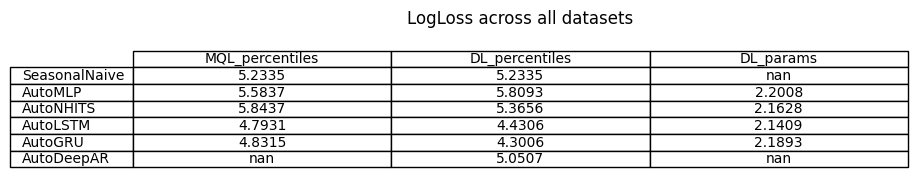

In [7]:
auc_global_MQL_percentiles = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])
auc_global_DL_percentiles = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])
auc_global_DL_params = pd.DataFrame(columns=['Model_Percentile','AUC','LogLoss'])

for dataset in [M3Dataset, TourismDataset, GluontsDataset]:
    for group in dataset.frequency_map.keys():
        MQL_percentiles = pd.read_csv(f"original_results/{dataset._DATASET_NAME}_{group}_MQLoss/auc_logloss_percentiles_{dataset._DATASET_NAME}_{group}_MQLoss.csv")
        DL_percentiles = pd.read_csv(f"original_results/{dataset._DATASET_NAME}_{group}_DistributionLoss/auc_logloss_percentiles_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")
        DL_params = pd.read_csv(f"original_results/{dataset._DATASET_NAME}_{group}_DistributionLoss/auc_logloss_params_{dataset._DATASET_NAME}_{group}_DistributionLoss.csv")
        
        auc_global_MQL_percentiles = pd.concat([auc_global_MQL_percentiles, MQL_percentiles], axis=0)
        auc_global_DL_percentiles = pd.concat([auc_global_DL_percentiles, DL_percentiles], axis=0)
        auc_global_DL_params = pd.concat([auc_global_DL_params, DL_params], axis=0)

matrix = {}
for df_name, df in [('MQL_percentiles', auc_global_MQL_percentiles), ("DL_percentiles", auc_global_DL_percentiles), ("DL_params", auc_global_DL_params)]:
    auc_means = {}
    for model in ['SeasonalNaive', 'AutoMLP', 'AutoNHITS', 'AutoLSTM', 'AutoGRU', 'AutoDeepAR']:
        auc = df[df['Model_Percentile'].isin([model+'_90', model+'_95', model+'_99'])]['LogLoss'].mean() 
        auc_means[model] = auc
    matrix[df_name] = auc_means

auc_df = pd.DataFrame(matrix)

fig, ax = plt.subplots(figsize=(10, 2))  # Set figure size
ax.axis('tight')
ax.axis('off')
ax.set_title("LogLoss across all datasets")

table = ax.table(cellText=auc_df.round(4).values, colLabels=auc_df.columns, rowLabels=auc_df.index, cellLoc='center', loc='center')
plt.savefig("plots/logloss_global_mean.png")

In [8]:
df = GluontsDataset.load_data("nn5_weekly")
df

INFO:root:downloading and processing nn5_weekly
Download nn5_weekly_dataset.zip:: 64.0kB [00:00, 81.3kB/s]
creating json files: 100%|██████████| 111/111 [00:00<00:00, 435517.07it/s]


,unique_id,ds,y
0,ID0,1996-03-24,141.964279
1,ID0,1996-03-31,160.714279
2,ID0,1996-04-07,165.300156
3,ID0,1996-04-14,153.642288
4,ID0,1996-04-21,147.689911
...,...,...,...
11650,ID110,1998-02-22,99.487114
11651,ID110,1998-03-01,126.827988
11652,ID110,1998-03-08,108.627037
11653,ID110,1998-03-15,98.844948


car parts
electricity
traffic
m3
tourism